In [3]:
import os

import matplotlib
import numpy as np
import sys
import yaml

sys.path.append('../')
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

from model import RecurrentNeuralNetwork
from posterior_inference_dataset import Posterior

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def make_signal(N, time_length, signal_length, mu, sigma):
    input_signals = np.zeros([N, time_length+1, 1])
    for i in range(N):
        signal = np.random.normal(mu, sigma, signal_length)
        input_signals[i, :signal_length, 0] = signal
    return input_signals

In [6]:
config_path = '../cfg/posterior/6_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)

In [7]:
cfg['MODEL']['SIGMA_PRIOR']

0.1

In [8]:
torch.manual_seed(1)
device = torch.device('cpu')

In [9]:
cfg['MODEL']['SIGMA_NEU'] = 0
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

if 'ALPHA' not in cfg['MODEL'].keys():
    cfg['MODEL']['ALPHA'] = 0.25

model = RecurrentNeuralNetwork(n_in=1, n_out=1, n_hid=cfg['MODEL']['SIZE'], device=device,
                               alpha_time_scale=cfg['MODEL']['ALPHA'], beta_time_scale=cfg['MODEL']['BETA'],
                               activation=cfg['MODEL']['ACTIVATION'],
                               sigma_neu=cfg['MODEL']['SIGMA_NEU'],
                               sigma_syn=cfg['MODEL']['SIGMA_SYN'],
                               use_bias=cfg['MODEL']['USE_BIAS'],
                               anti_hebbian=cfg['MODEL']['ANTI_HEBB']).to(device)

model_path = f'../trained_model/posterior/{model_name}/epoch_1000.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

model_name:  6_1


RecurrentNeuralNetwork(
  (w_in): Linear(in_features=1, out_features=512, bias=False)
  (w_hh): Linear(in_features=512, out_features=512, bias=True)
  (w_out): Linear(in_features=512, out_features=1, bias=False)
)

In [10]:
sample_num = 5000

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=30, signal_length=25, mu=0, sigma=0.2)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

In [11]:
neural_dynamics = np.zeros((sample_num, 31, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

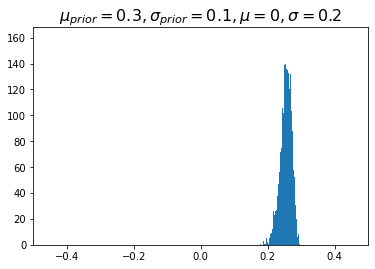

In [15]:
plt.hist(outputs_np, bins=100)
plt.xlim([-0.5, 0.5])
plt.title(r'$\mu_{prior}=0.3, \sigma_{prior}=0.1, \mu=0, \sigma=0.2$', fontsize=16)
plt.savefig('figures/model_7_1_mu_0_sigma_0.2.eps', dpi=200)
plt.savefig('figures/model_7_1_mu_0_sigma_0.2.png', dpi=200)

mu_posterior: 0.030, sigma_posterior: 0.190


(0.0, 2.6026104350168002)

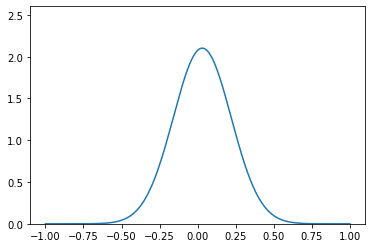

In [141]:
signal_mu = 0
signal_sigma = 0.2
mu_prior = cfg['MODEL']['MU_PRIOR']
sigma_prior = cfg['MODEL']['SIGMA_PRIOR']

mu_posterior = ((signal_sigma ** 2) * mu_prior +
                        (sigma_prior ** 2) * signal_mu) / (sigma_prior ** 2 + signal_sigma ** 2)
sigma_posterior = np.sqrt((signal_sigma ** 2)*(sigma_prior ** 2) / (sigma_prior ** 2 + signal_sigma ** 2) )
print(f'mu_posterior: {mu_posterior:.3f}, sigma_posterior: {sigma_posterior:.3f}')

def gauss(x, mu = 0, sigma = 1):
    return  np.exp(-((x - mu)**2) / (2*(sigma**2))) / (sigma*np.sqrt(2*np.pi))

x = np.arange(-1, 1, 0.001)

# グラフに描く関数
f1 = gauss(x, mu=mu_posterior, sigma=sigma_posterior)
# f1 = gauss(x, mu=mu_posterior, sigma=0.02)

plt.plot(x, f1)
plt.ylim([0, np.max(f1)+0.5])

In [150]:
sample_num = 1000

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=30, signal_length=25, mu=0, sigma=1)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

In [151]:
neural_dynamics = np.zeros((sample_num, 31, model.n_hid))                          
# hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
# hidden_np = np.zeros((cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

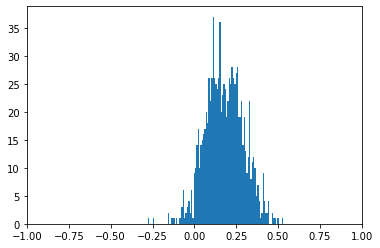

In [152]:
plt.hist(outputs_np, bins=100)
plt.xlim([-1, 1])
plt.show()

mu_posterior: 0.123, sigma_posterior: 0.384


(0.0, 1.5386129302236964)

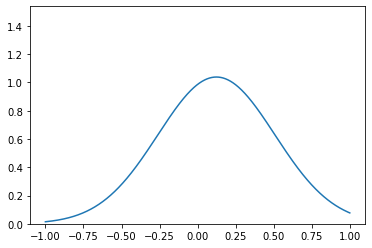

In [146]:
signal_mu = 0
signal_sigma = 0.5
mu_prior = cfg['MODEL']['MU_PRIOR']
sigma_prior = cfg['MODEL']['SIGMA_PRIOR']

mu_posterior = ((signal_sigma ** 2) * mu_prior +
                        (sigma_prior ** 2) * signal_mu) / (sigma_prior ** 2 + signal_sigma ** 2)
sigma_posterior = np.sqrt((signal_sigma ** 2)*(sigma_prior ** 2) / (sigma_prior ** 2 + signal_sigma ** 2) )
print(f'mu_posterior: {mu_posterior:.3f}, sigma_posterior: {sigma_posterior:.3f}')

def gauss(x, mu = 0, sigma = 1):
    return  np.exp(-((x - mu)**2) / (2*(sigma**2))) / (sigma*np.sqrt(2*np.pi))

x = np.arange(-1, 1, 0.001)

# グラフに描く関数
f1 = gauss(x, mu=mu_posterior, sigma=sigma_posterior)
# f1 = gauss(x, mu=mu_posterior, sigma=0.02)

plt.plot(x, f1)
plt.ylim([0, np.max(f1)+0.5])

In [57]:
sample_num = 3000

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=30, signal_length=25, mu=0, sigma=0.4)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

In [114]:
neural_dynamics = np.zeros((sample_num, 31, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   


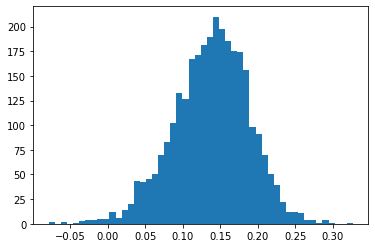

In [115]:
plt.hist(outputs_np, bins=50)
plt.show()

In [118]:
mu_list = [-1, -0.5, 0, 0.5, 1]
sigma_list = [0.1, 0.2, 0.3, 0.4, 0.5]
sample_num = 3000
for mu in mu_list:
    for sigma in sigma_list:
        outputs_np = np.zeros(sample_num)
        input_signal = make_signal(sample_num, time_length=30, signal_length=25, mu=mu, sigma=sigma)
        input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])
        
        neural_dynamics = np.zeros((sample_num, 31, model.n_hid))                                                                        
        for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
            hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
            hidden = torch.from_numpy(hidden_np).float()                               
            hidden = hidden.to(device)                                                                             
            inputs = torch.from_numpy(input_signal_split[i]).float()                                               
            inputs = inputs.to(device)                                                                             
            hidden_list, outputs, _ = model(inputs, hidden)                                                     
            hidden_list_np = hidden_list.cpu().detach().numpy()                          
            outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
            neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   
            
        activated = []
        for i in range(sample_num):
            tmp = neural_dynamics[0, -1, :]
            activated.append(len(tmp[tmp>0.05]))
        print(f'mu: {mu:.1f}, sigma: {sigma:.1f}, sparsness: {np.mean(activated) / cfg["MODEL"]["SIZE"]:.5f}')

mu: -1.0, sigma: 0.1, sparsness: 0.15234
mu: -1.0, sigma: 0.2, sparsness: 0.13867
mu: -1.0, sigma: 0.3, sparsness: 0.10352
mu: -1.0, sigma: 0.4, sparsness: 0.11328
mu: -1.0, sigma: 0.5, sparsness: 0.10742
mu: -0.5, sigma: 0.1, sparsness: 0.12109
mu: -0.5, sigma: 0.2, sparsness: 0.09375
mu: -0.5, sigma: 0.3, sparsness: 0.06250
mu: -0.5, sigma: 0.4, sparsness: 0.07422
mu: -0.5, sigma: 0.5, sparsness: 0.09375
mu: 0.0, sigma: 0.1, sparsness: 0.08789
mu: 0.0, sigma: 0.2, sparsness: 0.08984
mu: 0.0, sigma: 0.3, sparsness: 0.08984
mu: 0.0, sigma: 0.4, sparsness: 0.09961
mu: 0.0, sigma: 0.5, sparsness: 0.09375
mu: 0.5, sigma: 0.1, sparsness: 0.14453
mu: 0.5, sigma: 0.2, sparsness: 0.14258
mu: 0.5, sigma: 0.3, sparsness: 0.12500
mu: 0.5, sigma: 0.4, sparsness: 0.12305
mu: 0.5, sigma: 0.5, sparsness: 0.12305
mu: 1.0, sigma: 0.1, sparsness: 0.17773
mu: 1.0, sigma: 0.2, sparsness: 0.16602
mu: 1.0, sigma: 0.3, sparsness: 0.16602
mu: 1.0, sigma: 0.4, sparsness: 0.15625
mu: 1.0, sigma: 0.5, sparsness

In [60]:
neural_dynamics.shape

(3000, 31, 512)

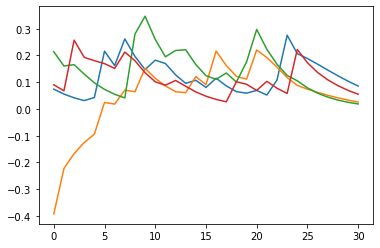

In [61]:
plt.plot(neural_dynamics[0, :, 4])
plt.plot(neural_dynamics[1, :, 4])
plt.plot(neural_dynamics[2, :, 4])
plt.plot(neural_dynamics[3, :, 4])

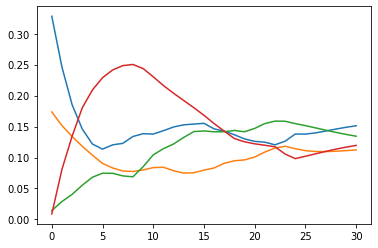

In [64]:
neuron_idx = 17
plt.plot(neural_dynamics[0, :, neuron_idx])
plt.plot(neural_dynamics[1, :, neuron_idx])
plt.plot(neural_dynamics[2, :, neuron_idx])
plt.plot(neural_dynamics[3, :, neuron_idx])

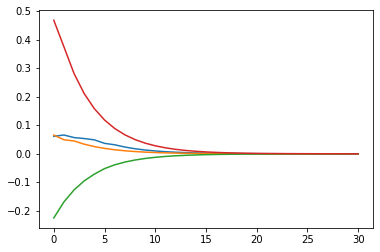

In [106]:
neuron_idx = 59
plt.plot(neural_dynamics[0, :, neuron_idx])
plt.plot(neural_dynamics[1, :, neuron_idx])
plt.plot(neural_dynamics[2, :, neuron_idx])
plt.plot(neural_dynamics[3, :, neuron_idx])

In [109]:
tmp = neural_dynamics[0, -1, :]

In [113]:
len(tmp[tmp>0.05])

48